# Biblioteki Pythona w analizie danych
### Tomasz Rodak

Lab 7

---



## Sieci neuronowe - problem regresji

Celem tego ćwiczenia jest:
- zdefiniowanie w Numpy własnej klasy `NeuralNetwork`, która będzie implementować sieć neuronową z jedną warstwą ukrytą w architekturze MLP (Multi-Layer Perceptron)
- zaimplementowanie algorytmu optymalizacji SGD (w wersji mini-batch) dla tej sieci

Dla uproszczenia będziemy zakładali, że wejście i wyjście sieci są ciągłe i mają wymiar 1.

### Architektura sieci neuronowej

Zaimplementuj sieć neuronową z jedną warstwą ukrytą o $n$ neuronach wg. wzoru:

\begin{equation*}
\begin{split}
z_1 &= a(w_1x + b_1) \\
z_2 &= a(w_2x + b_2) \\
&\vdots \\
z_n &= a(w_nx + b_n) \\
y &= v_1z_1 + v_2z_2 + \ldots + v_nz_n + b
\end{split}
\end{equation*}

Oznaczenia:
- $x$ - wejście sieci neuronowej,
- $z_i$ - wyjścia z neuronów warstwy ukrytej,
- $y$ - wyjście sieci neuronowej,
- $w_i$ - wagi wejść neuronów warstwy ukrytej,
- $b_i$ - przesunięcia neuronów warstwy ukrytej,
- $v_i$ - wagi wyjść neuronów warstwy ukrytej,
- $b$ - przesunięcie wyjścia sieci,
- $a$ - funkcja aktywacji (np. sigmoidalna).

Zapis macierzowy powyższego wzoru wygląda następująco.
Niech $X$ oznacza macierz obserwacji z dołączoną kolumną jedynek:

$$
X = \begin{bmatrix}
1 & x_1 \\
1 & x_2 \\
\vdots & \vdots \\
1 & x_N
\end{bmatrix}
$$

Jeśli $W$ oznacza macierz wag neuronów warstwy ukrytej postaci:

$$
W = \begin{bmatrix}
b_1 & b_2 & \ldots & b_n \\
w_1 & w_2 & \ldots & w_n
\end{bmatrix}
$$

to wyjścia neuronów warstwy ukrytej można zapisać jako:

$$
Z = a(XW)
$$

Podobnie, jeśli $V$ oznacza wektor wag wyjść neuronów warstwy ukrytej

$$
V = \begin{bmatrix}
b\\
v_1 \\
v_2 \\
\vdots \\
v_n
\end{bmatrix}
$$

to wyjście sieci można zapisać jako:

$$
y = \widetilde{Z}V
$$
gdzie $\widetilde{Z}$ to macierz $Z$ z dołączoną kolumną jedynek:
$$
\widetilde{Z} = \begin{bmatrix}
1 & z_{11} & z_{12} & \ldots & z_{1n} \\
1 & z_{21} & z_{22} & \ldots & z_{2n} \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
1 & z_{N1} & z_{N2} & \ldots & z_{Nn}
\end{bmatrix}
$$



### Funkcja straty

Jako funkcję straty przyjmij błąd średniokwadratowy (MSE - Mean Squared Error):

$$
L = \frac{1}{N} \sum_{i=1}^N (y_i - \hat{y}_i)^2
$$

gdzie $y_i$ to wartość rzeczywista, a $\hat{y}_i$ to wartość przewidziana przez sieć neuronową.

### Optymalizacja

Optymalizację sieci neuronowej wykonaj metodą SGD. Wagi sieci neuronowej zaktualizuj wg. wzoru:

$$
\begin{split}
W^{(t+1)} &= W^{(t)} - \eta \frac{\partial L}{\partial W} \\
V^{(t+1)} &= V^{(t)} - \eta \frac{\partial L}{\partial V}
\end{split}
$$

gdzie $\eta$ to współczynnik uczenia.

### Kod

Wykorzystaj powyższe wyjaśnienia i dokończ definicję klasy `NeuralNetwork` podaną poniżej.

In [24]:
import numpy as np

def sigmoid(a):
    """Sigmoidalna funkcja aktywacji."""
    return 1 / (1 + np.exp(-a))

def tanh(a):
    """Tangens hiperboliczny."""
    return np.tanh(a)

def relu(a):
    """Funkcja ReLU."""
    return np.maximum(0, a)


class NeuralNetwork:
    """Sieć neuronowa z jedną warstwą ukrytą,
    przeznaczona do regresji y = f(x).

    Warstwy:
    - wejściowa: 1 neuron plus bias
    - ukryta: n neuronów plus bias
    - wyjściowa: 1 neuron
    """

    def __init__(self, n=3, activation_function=sigmoid, seed=None):
        rng = np.random.RandomState(seed)
        self.W = rng.normal(0, 2, (2, n))
        self.V = rng.normal(0, 2, (n + 1, 1))
        self.activation_function = activation_function

    def forward(self, X):
        # Propagacja sygnału w przód
        # X: macierz danych wejściowych kształtu (N, 2), gdzie N to liczba próbek
        # Pierwsza kolumna to jedynki (bias), druga to x
        # Zwraca: wektor przewidywanych wartości kształtu (N, 1)
        Z = self.activation_function(X @ self.W)
        Z = np.hstack((np.ones((Z.shape[0], 1)), Z))
        return Z @ self.V

    def loss(self, X, y):
        # Oblicza błąd średniokwadratowy
        # X: macierz danych wejściowych kształtu (N, 2)
        # y: wektor wartości docelowych kształtu (N, 1)
        # Zwraca: błąd średniokwadratowy
        assert y.ndim == 2, "y musi być macierzą 2d"
        return np.mean((y - self.forward(X))**2)


    def gradient(self, X, y, h=1e-10):
        # Oblicza gradient funkcji straty numerycznie
        # X: macierz danych wejściowych kształtu (N, 2)
        # y: wektor wartości docelowych kształtu (N, 1)
        # h: krok numeryczny
        # Zwraca: krotka (dW, dV, db) z gradientami
        # dW: gradient macierzy wag W
        # dV: gradient macierzy wag V
        # db: gradient biasu b
        loss = self.loss(X, y)
        dW = np.empty_like(self.W, dtype=np.float64)
        for i in range(self.W.shape[0]):
            for j in range(self.W.shape[1]):
                self.W[i, j] += h
                dW[i, j] = (self.loss(X, y) - loss) / h
        dV = np.empty_like(self.V, dtype=np.float64)
        for i in range(self.V.shape[0]):
            for j in range(self.V.shape[1]):
                self.V[i, j] += h
                dV[i, j] = (self.loss(X, y) - loss) / h
                self.V[i, j] -= h
        return dW, dV

    def update(self, dW, dV, lr=0.01):
        # Aktualizuje wagi
        # dW: gradient macierzy wag W
        # dV: gradient macierzy wag V
        # lr: współczynnik uczenia
        self.W -= lr * dW
        self.V -= lr * dV

    def fit(self, X, y, epochs=1, lr=0.01, batch_size=1, verbose=False):
        # Uczy sieć
        # X: macierz danych wejściowych kształtu (N, 2)
        # y: wektor wartości docelowych kształtu (N, 1)
        # epochs: liczba epok
        # batch_size: rozmiar wsadu
        # lr: współczynnik uczenia
        # verbose: czy wypisywać wartości funkcji straty
        for epoch in range(epochs):
          idx = np.random.permutation(len(X))
          batches = np.array_split(idx, len(X) // batch_size)
          for batch in batches:
            X_batch = X[batch]
            y_batch = y[batch]
            dW, dV = self.gradient(X_batch, y_batch)
            self.update(dW, dV, lr)
          if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch}, loss: {self.loss(X, y)}")

In [21]:
import numpy as np
X = np.arange(5)[:,np.newaxis]
X = np.hstack((np.ones((X.shape[0], 1)), X))
y = np.sin(X[:,1])[:,np.newaxis]
X,y

(array([[1., 0.],
        [1., 1.],
        [1., 2.],
        [1., 3.],
        [1., 4.]]),
 array([[ 0.        ],
        [ 0.84147098],
        [ 0.90929743],
        [ 0.14112001],
        [-0.7568025 ]]))

In [22]:
nn=NeuralNetwork(activation_function=relu, seed = None)
nn.forward(X)


array([[ -2.25121064],
       [ -4.45893291],
       [ -6.66665519],
       [ -8.87437747],
       [-11.08209974]])

In [23]:
nn.loss(X,y)

### Testy

#### Zbiór danych treningowych

Na początek wygeneruj sztuczny zbiór danych treningowych z prostego modelu:

$$
y = \sin x + \varepsilon,\quad x \in [0, 10],\quad \varepsilon \sim N(0, 0.2).
$$

Wyświetl wykres funkcji odpowiadającej części deterministycznej modelu oraz wykres rozproszenia danych treningowych.

Dopasuj model sieci do danych treningowych dla różnych wartości hiperparametrów. Wyświetl uzyskane modele na wykresie wraz z danymi treningowymi.

Trudniejsze zadanie to aproksymacja funkcji ze zbioru [`D1`](https://github.com/rodakt/BPwAD/tree/main/data/D1)



In [80]:
N = 50
X = np.linspace(-5,5,N)[:, None]
y = X**2
X = np.hstack([np.ones((N,1)), X])

In [79]:
nn = NeuralNetwork(n=3,activation_function=tanh)

In [108]:
nn.fit(X,y, epochs=60000, lr=0.0001, verbose =True, batch_size = len(X))


Epoch 0, loss: 1.1481401531616484
Epoch 100, loss: 1.1470789484241064
Epoch 200, loss: 1.146019260996471
Epoch 300, loss: 1.144961085568446
Epoch 400, loss: 1.1439044112668784
Epoch 500, loss: 1.1428492360497051
Epoch 600, loss: 1.1417955605058125
Epoch 700, loss: 1.1407433925330877
Epoch 800, loss: 1.1396927225367983
Epoch 900, loss: 1.1386435441286324
Epoch 1000, loss: 1.1375958621657014
Epoch 1100, loss: 1.1365496759225748
Epoch 1200, loss: 1.1355049752174293
Epoch 1300, loss: 1.1344617666982106
Epoch 1400, loss: 1.13342004675123
Epoch 1500, loss: 1.132379815724915
Epoch 1600, loss: 1.131341067536321
Epoch 1700, loss: 1.1303037989079017
Epoch 1800, loss: 1.1292680087179492
Epoch 1900, loss: 1.1282336966264976
Epoch 2000, loss: 1.1272008648360898
Epoch 2100, loss: 1.1261695061317523
Epoch 2200, loss: 1.125139620758422
Epoch 2300, loss: 1.1241112063130267
Epoch 2400, loss: 1.1230842574286906
Epoch 2500, loss: 1.1220587754963853
Epoch 2600, loss: 1.1210347629052402
Epoch 2700, loss: 1.

<Axes: >

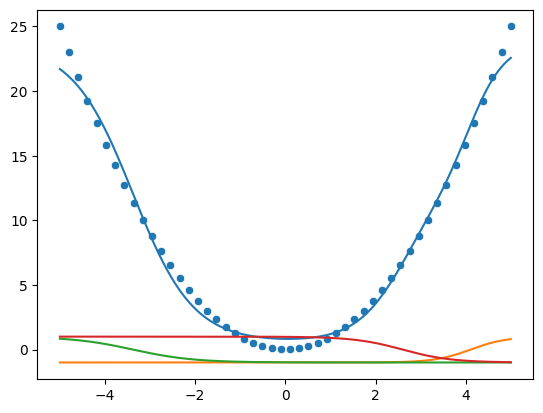

In [109]:
import seaborn as sns
xx = np.linspace(-5,5,1000)[:,None]
xx=np.hstack([np.ones((len(xx),1)),xx])
y_pred = nn.forward(xx)
sns.lineplot(x=xx[:,1], y=y_pred.ravel()) # Changed rave1 to ravel
sns.scatterplot(x=X[:,1],y=y.ravel()) # Changed rave1 to ravel

Z = nn.activation_function(xx @ nn.W)
sns.lineplot(x=xx[:,1],y=Z[:,0])
sns.lineplot(x=xx[:,1],y=Z[:,1])
sns.lineplot(x=xx[:,1],y=Z[:,2])

